---
# Boilerplate

In [2]:
# Typical imports
import numpy as np
from scipy.spatial import Delaunay
from skimage.draw import polygon2mask
from skimage.draw import polygon
from scipy.interpolate import RegularGridInterpolator
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from pylab import *
import cv2
import math
import sys
import os
import glob
from collections import defaultdict
import imageio 
print(sys.version)

3.11.4 (main, Jul  5 2023, 08:40:20) [Clang 14.0.6 ]


# For updating my helper functions (sometimes you need to run this block twice)

In [11]:
# My own helper functions
import julians_little_helpers 
from julians_little_helpers import * 
# For reloading my helper functions when I make changes to them
import importlib
importlib.reload(julians_little_helpers)

<module 'julians_little_helpers' from '/Users/julian/Code/cs180/proj4/code/julians_little_helpers.py'>

--- 
# Project 4A

# The photos I took to be stitched:

In [12]:
ims = []
filenames = sorted(glob.glob('../data/*.tiff'))
for filename in filenames:
    im = read_im(filename)
    ims.append(im)


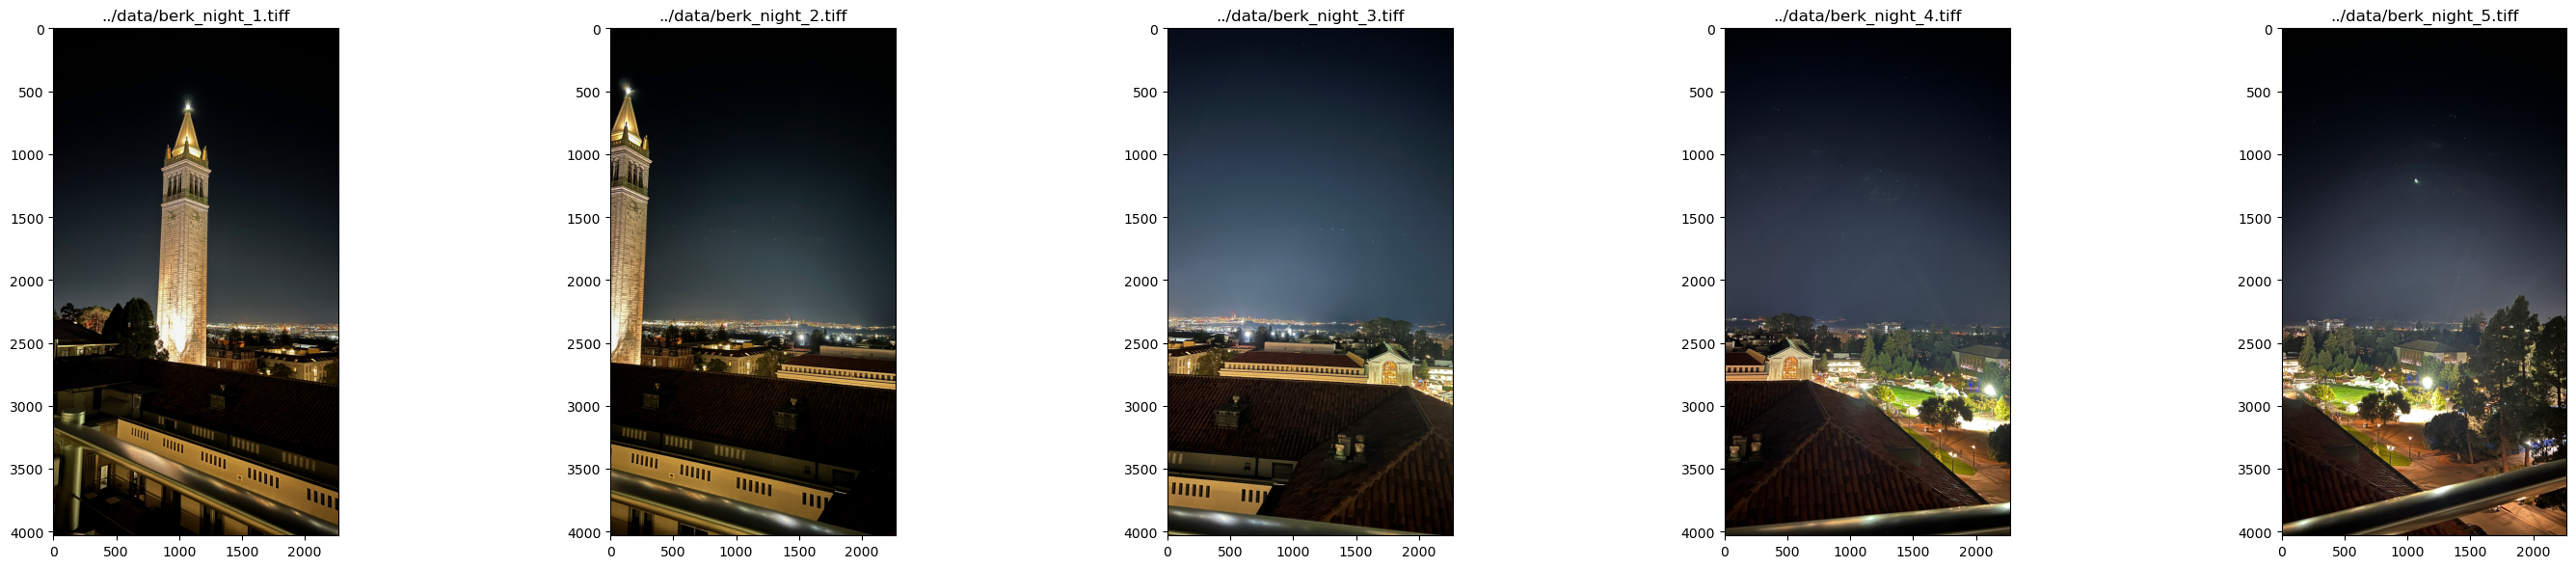

In [16]:
DisplayImages(ims, filenames, 6)

# Recovering Homographies
$$
p' = Hp
$$ 
Where H is a 3x3 matrix (with 8 degrees of freedom), p is a point in the original image, and p' is the point in the new image.
Will need to write a function that recovers the homography via a set of corresponding points $(p, p')$. 

`H = computeH(im1_pts, im2_pts)`

Where `im1_pts` and `im2_pts` are n by 2 matrices of corresponding points in the two images.

In order to solve for the entries of matrix `H` we will need to setup a linear system of n equations, which can be written as 
$$Ah = b$$ 
where $h$ is a vector of the 8 entries of `H`. More than 4 correspondances should be provided to produce an overdetermined system which can be solved using least squares. (This will be more stable than if we chose 4 correspondances and solved using a direct method.)

For the purposes of the first part of this project, I will manually determine the correspondancs using a tool like [GIMP](https://www.gimp.org/).

For `computeH()` I will probably use `np.linalg.lstsq()` or `scipy.optimize.least_squares()` or `scipy.optimize.nnls()` probably using a contraint on `h` to make it have magnitude of 1. As of right now I'm not entirely sure if I need to constrain it or not.

In [18]:
def computeH(im1_pts, im2_pts):
    """
    Inputs:
        im1_pts: nx2 matrix of points from image 1 (x,y).
        im2_pts: nx2 matrix of points from image 2 (x,y).
        n >= 4 
    Returns:
        H: 3x3 Homography matrix from image 1 to image 2.
    Strategy:
        A = [[x y 1 0 0 0 -x*x' -y*x']
             [0 0 0 x y 1 -x*y' -y*y']
             ...]] 
        h = [a b c d e f g h]^T
        b = [x' y' ...]^T
        Solve Ah = b for h.
        Reshape to 3x3.
    """
    # Solve the linear system Ah = b
    A = np.zeros((2*im1_pts.shape[0], 8))
    b = np.zeros((2*im1_pts.shape[0], 1))
    for i in range(im1_pts.shape[0]):
        x1, y1 = im1_pts[i]
        x2, y2 = im2_pts[i]
        A[2*i,   :] = np.array([x1, y1, 1,  0,  0, 0, -x1*x2, -y1*x2])
        A[2*i+1, :] = np.array([ 0,  0, 0, x1, y1, 1, -x1*y2, -y1*y2])
        b[2*i,   :] = x2
        b[2*i+1, :] = y2
    h = np.linalg.lstsq(A, b, rcond=None)[0]
    h = np.append(h, 1)
    H = h.reshape((3,3))
    return H

In [28]:
# Test computeH
im1_pts = np.array([[1, 1], [1, 2], [2, 1], [2, 2]])
im2_pts = np.array([[2, 2], [2, 3], [3, 2], [3, 3]])
H = computeH(im1_pts, im2_pts)
H_inv = np.linalg.inv(H)
for i in range(im1_pts.shape[0]):
    assert np.allclose(H @ np.append(im1_pts[i], 1), np.append(im2_pts[i], 1))
    assert np.allclose(np.append(im1_pts[i], 1), H_inv @ np.append(im2_pts[i], 1))

# Manually get a bunch of correspondances.
# For simplicity's sake, I will just stitch 2 images together for now.

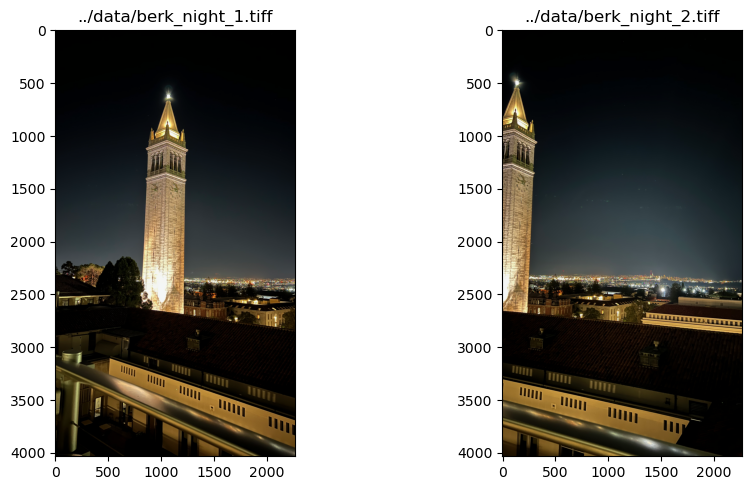

(4032, 2268, 3) (4032, 2268, 3)


In [32]:
DisplayImages(ims[:2], filenames[:2], 5)
im1, im2 = ims[:2]
print(im1.shape, im2.shape)

In [ ]:
# (x,y) format (0,0) is top left
im1_pts = [
    [1075, 537], # very top of campinele
    [1057, 1040], # middle corner of ledge on campinele
    [1354, 3424], # top left corner of window to the left of white box
    [2086, 2759], # bottom right corner of bright window on wheeler
    [2047, 3757], # bottom right corner of leftmost window of the the last row of windows on lower building
    [1656, 3529], # top right corner of 3rd window to the right of white box
    [1032, 3380], # bottom right corner of 1st window of row of windows 2nd to the left of the white box
    [1357, 2438], # bottom right corner of church tower
]

In [ ]:
# (x,y) format (0,0) is top left
im2_pts = [
    [148, 403],
    [116, 935],
    [358, 3421],
    [1097, 2706],
    [1555, 3791],
    [663, 3491],
    [8, 3415],
    [400, 2416],
]

# Warp the Images

# Image Rectification

# Blend Images into Mosaic

# Most Important/Coolest thing I've learned from this part?